<font size="10">Simulating Diffusion with PINNs</font>

<font size="4">This notebook employs a physics informed neural network (PINN) to simulate the solution to the linear diffusion equation
$\partial_t u = \partial_x^2u,$
with $x \in [-1,1]$ and $t\in [0,1]$. The initial condition is taken to be $u(x,0) = \cos(\pi x)$ and we consider Neumann boundary conditions.</font>

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 5.4 of the book. <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network</font>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
from time import time

In [2]:
dtype = torch.float32

# Set constants
pi = torch.tensor(np.pi, dtype=dtype)
viscosity = torch.tensor(0.1, dtype=dtype)

# Define initial condition
def fun_u_0(x):
    return torch.cos(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return torch.zeros((n,1), dtype=dtype)

# Define residual of the PDE
def fun_r(u_t, u_xx):
    return u_t - viscosity * u_xx

In [3]:
# Set number of data points
N_0 = 500
N_b = 1000
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lower bounds
lb = torch.tensor([tmin, xmin], dtype=dtype).to(device)
# Upper bounds
ub = torch.tensor([tmax, xmax], dtype=dtype).to(device)

# Set random seed for reproducible results
torch.manual_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = torch.ones((N_0,1), dtype=dtype).to(device)*lb[0]
x_0 = torch.rand((N_0,1), dtype=dtype).to(device) * (ub[1]-lb[1]) + lb[1]
X_0 = torch.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = torch.rand((N_b,1), dtype=dtype, requires_grad=True).to(device) * (ub[0]-lb[0]) + lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(0.5 * torch.ones((N_b, 1), dtype=dtype, requires_grad=True).to(device))
X_b = torch.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True).to(device) * (ub[0]-lb[0]) + lb[0]
x_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True).to(device) * (ub[1]-lb[1]) + lb[1]
X_r = torch.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

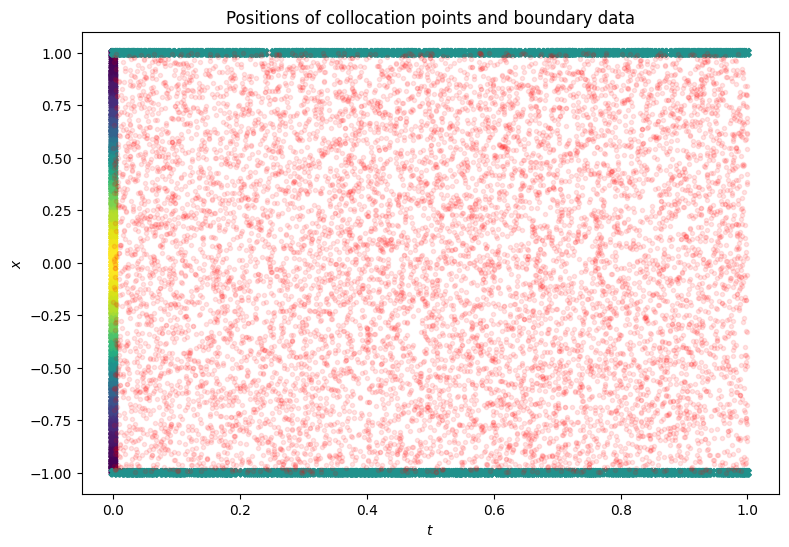

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0.cpu().detach(), x_0.cpu().detach(), c=u_0.cpu().detach(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_b.cpu().detach(), x_b.cpu().detach(), c=u_b.cpu().detach(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_r.cpu().detach(), x_r.cpu().detach(), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        # Input is two-dimensional (time + one spatial dimension)
        self.input_layer = nn.Linear(2, num_neurons_per_layer)

        # Append hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer,num_neurons_per_layer)

            for _ in range(num_hidden_layers)
        ])

        # Output is one-dimensional
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        # Introduce a scaling to map input to [lb, ub]
        x = 2.0*(x - lb)/(ub - lb) - 1.0

        # Forward pass through layers
        x = torch.tanh(self.input_layer(x))
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        x = self.output_layer(x)
        return x

In [5]:
def compute_loss(model, X_r, X_data, u_data):
    X_r = X_r.detach().requires_grad_(True)

    # Split t and x to compute partial derivatives
    t,x = X_r[:,0:1], X_r[:,1:2]

    # Determine u
    u = model(torch.cat([t,x],dim=1))

    # Compute gradients
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),create_graph=True, allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u),create_graph=True, allow_unused=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),create_graph=True, allow_unused=True)[0]

    # Compute loss
    loss = torch.mean(torch.square(fun_r(u_t, u_xx)))

    # Initial conditions in loss
    x0 = X_data[0]
    u0 = model(x0)
    loss += torch.mean(torch.square(u_data[0]-u0))

    # Neumann boundary conditions
    # Split t and x to compute partial derivatives
    tb, xb = X_data[1][:,0:1].detach().requires_grad_(True), X_data[1][:,1:2].detach().requires_grad_(True)

    # Determine residual
    ub = model(torch.cat([tb, xb],dim=1))

    # Compute gradient
    ub_x = torch.autograd.grad(ub, xb,create_graph=True, grad_outputs=torch.ones_like(ub), allow_unused=True)[0]
    loss += torch.mean(torch.square(ub_x))

    return loss

In [6]:
model = NeuralNetwork().to(device)

# Learning rate schedule
lr_schedule = [1e-2, 1e-3, 1e-4]
def get_lr(epoch):
    if epoch < 1000:
        return lr_schedule[0]
    elif epoch < 3000:
        return lr_schedule[1]
    else:
        return lr_schedule[2]

# Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr_schedule[0])

In [20]:
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = get_lr(i)

    # Reset gradient of optimizer to 0
    optimizer.zero_grad()

    # Compute loss
    loss = compute_loss(model, X_r, X_data, u_data)
    loss.backward()

    # Perform gradient descent step
    optimizer.step()

    # Append current loss to hist
    hist.append(loss.item())

    # Output current loss after 50 iterates
    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss.item()))

        # Implementing early stopping
        if loss.item() < 1e-5:
            break

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


It 00000: loss = 8.72784317e-01
It 00050: loss = 8.80921558e-02
It 00100: loss = 5.73495310e-03
It 00150: loss = 4.22067661e-03
It 00200: loss = 2.38095783e-03
It 00250: loss = 1.64879002e-02
It 00300: loss = 1.49227213e-03
It 00350: loss = 1.56923465e-03
It 00400: loss = 2.82310438e-03
It 00450: loss = 6.13414799e-04
It 00500: loss = 8.11911537e-04
It 00550: loss = 5.30672085e-04
It 00600: loss = 5.92112716e-04
It 00650: loss = 8.15144740e-04
It 00700: loss = 1.73406512e-03
It 00750: loss = 1.63538591e-03
It 00800: loss = 2.22459203e-03
It 00850: loss = 5.63382776e-03
It 00900: loss = 1.62292260e-03
It 00950: loss = 1.75782992e-03
It 01000: loss = 1.02288811e-03
It 01050: loss = 1.54971232e-04
It 01100: loss = 1.37550713e-04
It 01150: loss = 1.26924599e-04
It 01200: loss = 1.18327429e-04
It 01250: loss = 1.11069072e-04
It 01300: loss = 1.04778846e-04
It 01350: loss = 9.92297064e-05
It 01400: loss = 9.42710612e-05
It 01450: loss = 8.97963473e-05
It 01500: loss = 8.57258347e-05
It 01550

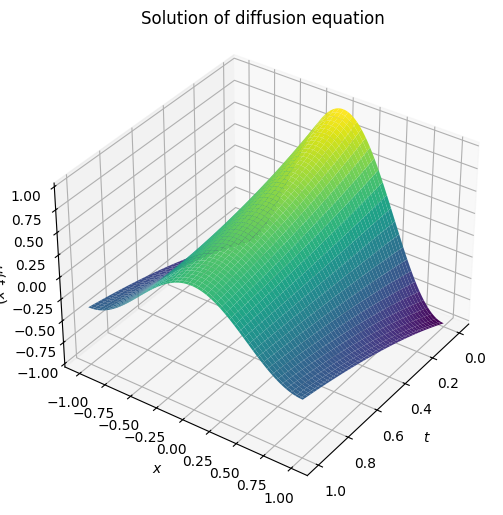

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
tspace = np.linspace(tmin, tmax, N + 1)
xspace = np.linspace(xmin, xmax, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(torch.tensor(Xgrid,dtype=dtype).to(device))

# Reshape upred
U = upred.cpu().detach().numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(t,x)$')
ax.set_title('Solution of diffusion equation');